In [ ]:
import pandas as pd
import torch
from transformers import pipeline, AutoTokenizer
import re
import gc

# Load sentiment analysis model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define file paths
file_path = "Batch_one/filtered_steemit_2024-03-11.csv"  # Update with actual file
output_path = "Batch_one/sentiment_results.csv"

def process_text(text):
    """Removes URLs, non-alphabetic characters, and extra spaces."""
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text


#Code to name the files and file path here. 
def analyze_sentiment(text):
    """Get sentiment score and label from the model."""
    # Truncate text to the maximum sequence length
    # The problem was here, passing the whole tokenized output
    # Now we only pass the text part
    result = sentiment_pipeline(text, truncation=True, max_length=512, return_all_scores=False)[0]
    score = int(result['label'][0])  # Extract numeric rating
    return score, result['label']


In [ ]:
def process_chunk(chunk, output_path, first_chunk=True):
    """Process a chunk of data and save results."""
    chunk['processed_text'] = chunk['text'].apply(process_text)
    chunk[['sentiment_score', 'sentiment_category']] = chunk['processed_text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

    # Save the chunk to the output file
    if first_chunk:
        chunk.to_csv(output_path, mode='w', header=True, index=False)
    else:
        chunk.to_csv(output_path, mode='a', header=False, index=False)

    # Release memory and collect garbage
    del chunk
    gc.collect()

# Read the CSV in chunks and process each chunk
chunk_size = 1  # Reducing to 1 rows per chunk for better memory management
first_chunk = True

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    process_chunk(chunk, output_path, first_chunk)
    first_chunk = False  # After first chunk, set to False to append to file

print(f"Sentiment analysis completed. Results saved to: {output_path}")


In [2]:
import pandas as pd
df2 = pd.read_csv('/Users/samsonbobo/Desktop/Research Topic/Thesis/sentiment_results.csv')
df2.head(2)

,timestamp,title,text,concatenated_text,processed_text,sentiment_score,sentiment_category
0,2024-03,Enjoy faster browsing and get easy money,"CryptoTab Browser – high performance, clean de...",Enjoy faster browsing and get easy money . Cry...,CryptoTab Browser high performance clean desig...,5,5 stars
1,2024-03,I finished a cup of roselle flower tea with a ...,"**<div class=""phishy""> HELLO EVERYONE.. </div>...",I finished a cup of roselle flower tea with a ...,div classphishy HELLO EVERYONE divnndiv classt...,1,1 star


In [ ]:
import torch
import gc
import pandas as pd
from transformers import pipeline, AutoTokenizer

# Set device (0 = GPU, -1 = CPU)
device = 0 if torch.cuda.is_available() else -1

# Load the zero-shot classification model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

# Load tokenizer to handle truncation
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")

# Define candidate topics
candidate_labels = [
    "politics", "sports", "technology", "health", "entertainment", "business",
    "education", "food", "travel", "climate", "relationships", "science",
    "religion", "economy", "crime", "military", "fashion", "music", "movies", "personal",
]



def classify_text(text):
    """Classifies text into a topic while handling memory issues."""
    # Tokenize and truncate text to fit within the model limit
    inputs = tokenizer(text, truncation=True, max_length=500, return_tensors="pt")

    # Convert tokenized text back to string (ensuring it remains truncated)
    truncated_text = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)

    # Perform classification on truncated text
    result = classifier(truncated_text, candidate_labels, multi_label=True)

    # Get the most relevant category
    best_category = result["labels"][0]

    return best_category

# Process rows in chunks
def process_chunk(chunk):
    """Processes a chunk of data and releases memory."""
    chunk["category"] = chunk["text"].apply(classify_text)

    # Release GPU memory
    gc.collect()
    torch.cuda.empty_cache()

    return chunk

# File paths
input_file = "/content/sentiment_results.csv"
output_file = "sentiment_results_with_category.csv"

# Process file in chunks to manage memory
chunk_size = 1  # Process one row at a time to prevent memory overflow
first_chunk = True

for chunk in pd.read_csv(input_file, chunksize=chunk_size):
    processed_chunk = process_chunk(chunk)

    # Save to CSV
    if first_chunk:
        processed_chunk.to_csv(output_file, mode="w", index=False)
        first_chunk = False
    else:
        processed_chunk.to_csv(output_file, mode="a", header=False, index=False)

    # Additional memory cleanup
    del processed_chunk
    gc.collect()
    torch.cuda.empty_cache()

print(f"Processing completed. Results saved to {output_file}")


In [4]:
df3 = pd.read_csv('/Users/samsonbobo/Desktop/Research Topic/Thesis/sentiment_results_with_category.csv')
df3.head(5)

,timestamp,title,text,concatenated_text,processed_text,sentiment_score,sentiment_category,category
0,2024-03,Enjoy faster browsing and get easy money,"CryptoTab Browser – high performance, clean de...",Enjoy faster browsing and get easy money . Cry...,CryptoTab Browser high performance clean desig...,5,5 stars,technology
1,2024-03,I finished a cup of roselle flower tea with a ...,"**<div class=""phishy""> HELLO EVERYONE.. </div>...",I finished a cup of roselle flower tea with a ...,div classphishy HELLO EVERYONE divnndiv classt...,1,1 star,entertainment
2,2024-03,The latest BTC - STEEM - SBD prices update,"Hello!\n\nThe latest BTC, STEEM and SBD update...",The latest BTC - STEEM - SBD prices update . H...,HellonnThe latest BTC STEEM and SBD updatenn B...,1,1 star,relationships
3,2024-03,Bitcoin ATH and still moving,![image.png](https://cdn.steemitimages.com/DQm...,Bitcoin ATH and still moving . ![image.png](ht...,imagepng I am saying goodnight it is still Fri...,3,3 stars,business
4,2024-03,Achievement 1: MARI KITA BERKENALAN,"@@ -1,65 +1,80 @@\n-Achievement 1: Mari Kita K...","Achievement 1: MARI KITA BERKENALAN . @@ -1,65...",nAchievement Mari Kita Kenalan nCdiv class tex...,1,1 star,health


In [ ]:
import pandas as pd
import torch
import gc
from transformers import AutoTokenizer
from keybert import KeyBERT
from sklearn.feature_extraction.text import TfidfVectorizer

# Load KeyBERT model
kw_model = KeyBERT()

# Load Tokenizer to check max token limit
bert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
max_tokens = bert_tokenizer.model_max_length  # Get the max token limit

# Load sentiment results
input_file = "/content/sentiment_results_with_category.csv"
df = pd.read_csv(input_file)

# Filter rows where sentiment score is 5
df = df[df['sentiment_score'] == 5]

# Initialize TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
vectorizer.fit(df['processed_text'].dropna())  # Fit on non-null texts

# Function to extract keywords dynamically
def extract_keywords(text, category):
    if pd.isna(text):
        return ""

    # Truncate text to max token length
    tokenized_text = bert_tokenizer.tokenize(text)
    truncated_text = bert_tokenizer.convert_tokens_to_string(tokenized_text[:max_tokens])

    # Use KeyBERT with category as context
    keywords = kw_model.extract_keywords(
        truncated_text,
        keyphrase_ngram_range=(1, 3),
        stop_words='english',
        top_n=3,
        use_mmr=True,
        diversity=0.7
    )

    # Extract top keywords
    extracted_keywords = [kw[0] for kw in keywords]
    return ", ".join(extracted_keywords)

# Apply keyword extraction
df['keywords'] = df.apply(lambda row: extract_keywords(row['processed_text'], row['category']), axis=1)

# Select relevant columns for clustering
df_output = df[['timestamp', 'keywords', 'category']]

# Save to CSV
output_file = "topics_for_clustering.csv"
df_output.to_csv(output_file, index=False)

gc.collect()

print(f"Keyword extraction completed. Results saved to {output_file}")


In [5]:
df4 = pd.read_csv('/Users/samsonbobo/Desktop/Research Topic/Thesis/topics_for_clustering.csv')
df4.head(5)

,timestamp,keywords,category
0,2024-03,"cryptotab browser, android mobile version, per...",technology
1,2024-03,"highcryptoprofit gaming, nndawn refuge lets, g...",technology
2,2024-03,"enjoy cooking, class phishyconclusiondivcenter...",food
3,2024-03,"enjoy cooking, class phishyconclusiondivcenter...",food
4,2024-03,"speech recognition technology, commands, absol...",technology


In [10]:
!pip install numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/38 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Best min_cluster_size: 50


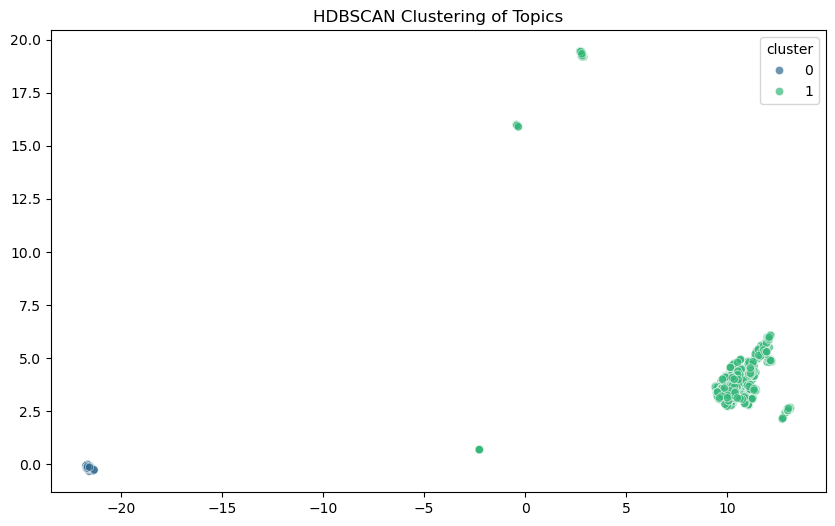

Clustering completed and results saved.


In [1]:
import pandas as pd
import numpy as np
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Load the dataset
file_path = "/Users/samsonbobo/Desktop/Research Topic/Thesis/topics_for_clustering.csv"
df = pd.read_csv(file_path)

# Extract relevant columns
keywords = df['keywords'].astype(str)
categories = df['category']

# Convert keywords to numerical features
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
X_tfidf = vectorizer.fit_transform(keywords)

# Use sentence embeddings for better clustering
model = SentenceTransformer("all-MiniLM-L6-v2")
X_embeddings = model.encode(keywords, convert_to_numpy=True, show_progress_bar=True)

# Reduce dimensionality for clustering
X_reduced = umap.UMAP(n_components=10, random_state=42).fit_transform(X_embeddings)

# Optimize HDBSCAN parameters
def find_best_cluster_size(X, min_size_range=[3, 10, 20, 50]):
    best_score = -1
    best_size = None
    best_labels = None

    for min_size in min_size_range:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size, min_samples=3, metric='euclidean', cluster_selection_method='eom')
        labels = clusterer.fit_predict(X)

        if len(set(labels)) > 1:  # Ensure we have multiple clusters
            score = silhouette_score(X, labels)
            if score > best_score and score >= 0.65:
                best_score = score
                best_size = min_size
                best_labels = labels

    return best_size, best_labels

# Find optimal min_cluster_size
best_size, best_labels = find_best_cluster_size(X_reduced)
print(f"Best min_cluster_size: {best_size}")

df['cluster'] = best_labels

# Save clustered results
df.to_csv("clustered_topics.csv", index=False)

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['cluster'], palette='viridis', alpha=0.7)
plt.title("HDBSCAN Clustering of Topics")
plt.show()

gc.collect()
print("Clustering completed and results saved.")


In [2]:
import pandas as pd
import re
from collections import Counter

# Load clustered data
file_path = "/Users/samsonbobo/Desktop/Research Topic/Thesis/clustered_topics.csv"  # Update this if needed
df = pd.read_csv(file_path)

# Step 1: Clean the keywords to ensure they are readable English words
def clean_keywords(text):
    words = re.findall(r'\b[a-zA-Z]+\b', str(text))  # Keep only English words
    return " ".join(words)

df['cleaned_keywords'] = df['keywords'].apply(clean_keywords)

# Step 2: Identify representative words/phrases per cluster
def get_top_keywords(keywords, top_n=5):
    words = " ".join(keywords).split()
    word_counts = Counter(words)
    return " ".join([word for word, _ in word_counts.most_common(top_n)])

cluster_topics = df.groupby("cluster")["cleaned_keywords"].apply(lambda x: get_top_keywords(x, top_n=5)).reset_index()
cluster_topics.columns = ["cluster", "representative_keywords"]

# Step 3: Merge with categories for analysis
final_df = df.merge(cluster_topics, on="cluster", how="left")

# Save results
output_path = "final_topics.csv"
final_df.to_csv(output_path, index=False)

print(f"Representative topics extracted and saved to: {output_path}")


Representative topics extracted and saved to: final_topics.csv


In [3]:
df5 = pd.read_csv('/Users/samsonbobo/Desktop/Research Topic/Thesis/final_topics.csv')
df5.head()

,timestamp,keywords,category,cluster,cleaned_keywords,representative_keywords
0,2024-03,"cryptotab browser, android mobile version, per...",technology,1,cryptotab browser android mobile version perfo...,href love android br got
1,2024-03,"highcryptoprofit gaming, nndawn refuge lets, g...",technology,1,highcryptoprofit gaming nndawn refuge lets goa...,href love android br got
2,2024-03,"enjoy cooking, class phishyconclusiondivcenter...",food,1,enjoy cooking class phishyconclusiondivcentern...,href love android br got
3,2024-03,"enjoy cooking, class phishyconclusiondivcenter...",food,1,enjoy cooking class phishyconclusiondivcentern...,href love android br got
4,2024-03,"speech recognition technology, commands, absol...",technology,1,speech recognition technology commands absolut...,href love android br got
